In [1]:
import pandas as pd
from utils.utils import load_all_games_csv, get_teams
from elos.elo_tracker import EloTracker
import numpy as np
from sklearn.metrics import log_loss, accuracy_score
from sklearn.linear_model import LogisticRegression
from scipy.special import expit
from matplotlib import pyplot as plt

# Win Probability Analysis

This notebook will compare several different methods to estimate win probabilities from Elo ratings, and possibly home advantage, travel distance, and rest days.

## Get all Games

In [2]:
all_games = load_all_games_csv('../data/gameinfo_cleaned.csv')

/Users/lancehendricks/Documents/College Coding/ML/Elo Ratings/src/utils/utils.py:18: DtypeWarning: Columns (10,11,13,17,19,21,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  all_games = pd.read_csv(filename)


## Get Elo Rating History

In [3]:
teams = get_teams(all_games)

et = EloTracker(teams)

et.add_history(all_games)

In [4]:
# Add raw pre-game Elo Ratings
all_games['homeelo'] = [0] * len(all_games)
all_games['viselo'] = [0] * len(all_games)

for team in teams:
    for game in et.elos_map[team]:
        gid = game[0]
        elo = game[3]
        
        if all_games.loc[gid,'hometeam'] == team:
            all_games.loc[gid,'homeelo'] = elo
        else:
            all_games.loc[gid,'viselo'] = elo
        

In [5]:
# Drop rows with na travel distance
all_games = all_games.dropna(subset='visdistancetraveled').copy()
all_games[all_games.isna().any(axis=1)]

,visteam,hometeam,site,date,number,starttime,daynight,innings,tiebreaker,usedh,...,season,homewon,timestamp,Latitude,Longitude,visdistancetraveled,homerestdays,visrestdays,homeelo,viselo
gid,,,,,,,,,,,,,,,,,,,,,
LS3189904140,CHN,LS3,LOU03,18990414,0.0,0:00PM,day,NaN,NaN,False,...,1899,0,1899-04-14 12:00:00,38.247254,-85.799672,269.187008,365,365,1488,1512
PHI189904140,WSN,PHI,PHI09,18990414,0.0,0:00PM,day,NaN,NaN,False,...,1899,1,1899-04-14 12:00:00,39.993268,-75.155638,124.167063,365,365,1512,1488
BLN189904150,NY1,BLN,BAL07,18990415,0.0,0:00PM,day,NaN,NaN,False,...,1899,1,1899-04-15 12:00:00,39.317361,-76.612034,175.916531,365,365,1512,1488
BRO189904150,BSN,BRO,NYC12,18990415,0.0,0:00PM,day,NaN,NaN,False,...,1899,0,1899-04-15 12:00:00,40.675411,-73.986773,188.873979,365,365,1488,1512
CIN189904150,PIT,CIN,CIN05,18990415,0.0,0:00PM,day,NaN,NaN,False,...,1899,0,1899-04-15 12:00:00,39.116804,-84.535870,257.190815,365,365,1488,1512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LAN202410250,NYA,LAN,LOS03,20241025,0.0,5:08PM,night,9.0,NaN,True,...,2024,1,2024-10-25 17:08:00,34.073878,-118.239951,2448.420713,5,6,1653,1565
LAN202410260,NYA,LAN,LOS03,20241026,0.0,5:08PM,night,9.0,NaN,True,...,2024,1,2024-10-26 17:08:00,34.073878,-118.239951,2448.420713,1,1,1662,1556
NYA202410280,LAN,NYA,NYC21,20241028,0.0,8:08PM,night,9.0,NaN,True,...,2024,0,2024-10-28 20:08:00,40.829586,-73.926413,2448.420713,2,2,1548,1670


## Evaluate Simple Probability model

In [6]:
def basic_win_prob(home_elo: float, away_elo: float) -> float:
    """Fetches the basic Elo probability the home team wins, given each team's Elo.
    
    The basic Elo probability is given by 1 / (1+10^((away_elo - home_elo) / 400).
    
    Args:
        home_elo (float): Home team Elo.
        away_elo (float): Away team Elo.
        
    Returns:
        float: The basic probability the home team wins.
    """
    return 1 / (1+10**((away_elo - home_elo) / 400))

In [7]:
all_games['homewinprob'] = all_games.apply(lambda game: basic_win_prob(game['homeelo'], game['viselo']), axis=1)
print("BCE:", log_loss(all_games['homewon'], all_games['homewinprob']))
print("Accuracy:", accuracy_score(all_games['homewon'], all_games['homewinprob'].apply(lambda x: 1 if x >= 0.5 else 0)))

BCE: 0.6238936941957086
Accuracy: 0.6663960054132251


(array([  301.,  3735., 14992., 35120., 51242., 52080., 36951., 16049.,
         3490.,   330.]),
 array([0.08671721, 0.16968762, 0.25265804, 0.33562846, 0.41859887,
        0.50156929, 0.58453971, 0.66751013, 0.75048054, 0.83345096,
        0.91642138]),
 <BarContainer object of 10 artists>)

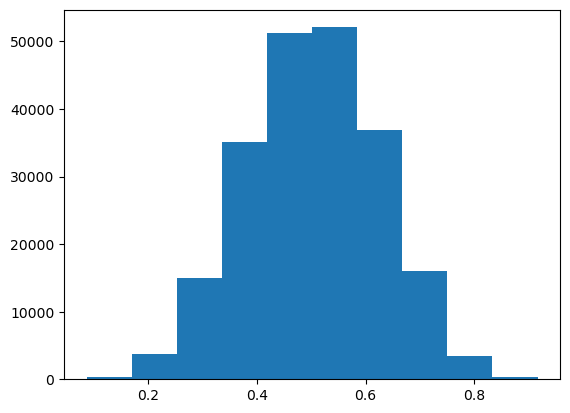

In [8]:
plt.hist(all_games['homewinprob'])

## With + 1.9% Adjustment for Home Team

In [9]:
def win_prob_home_pct_adj(home_elo: float, away_elo: float, home_pct_adj=.019) -> float:
    """Fetches probability the home team wins, given each team's Elo, with a % boost of home_pct_adj to the home team elo..
    
    The probability is given by 1 / (1+10^((away_elo - (1+home_pct_adj)*home_elo) / 400).
    
    Args:
        home_elo (float): Home team Elo.
        away_elo (float): Away team Elo.
        
    Returns:
        float: The basic probability the home team wins.
    """
    return 1 / (1+10**((away_elo - (1+home_pct_adj)*home_elo) / 400))

In [10]:
all_games['homewinprob'] = all_games.apply(lambda game: win_prob_home_pct_adj(game['homeelo'], game['viselo']), axis=1)
print("BCE:", log_loss(all_games['homewon'], all_games['homewinprob']))
print("Accuracy:", accuracy_score(all_games['homewon'], all_games['homewinprob'].apply(lambda x: 1 if x >= 0.5 else 0)))

BCE: 0.6209700505861759
Accuracy: 0.6660833449997666


(array([  217.,  2467., 10595., 27293., 45069., 55945., 43437., 23021.,
         5755.,   491.]),
 array([0.09905898, 0.18204663, 0.26503427, 0.34802192, 0.43100957,
        0.51399721, 0.59698486, 0.67997251, 0.76296015, 0.8459478 ,
        0.92893545]),
 <BarContainer object of 10 artists>)

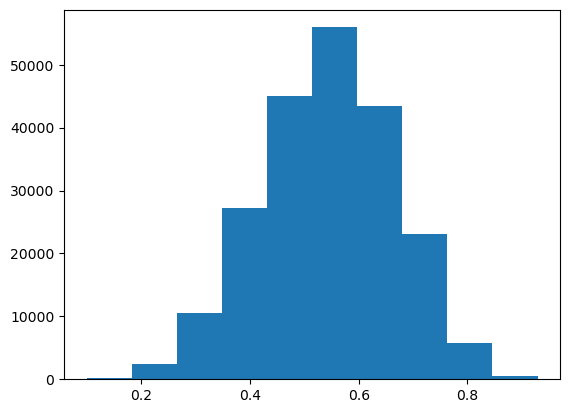

In [11]:
plt.hist(all_games['homewinprob'])

## With Logistic Regression

In [ ]:
all_games['visminushomeelo'] = all_games['viselo'] - all_games['homeelo']
all_games['visminushomerestdays'] = all_games['visrestdays'] - all_games['homerestdays']
all_games['visminushometraveldist'] = all_games['visdistancetraveled'] - 0
all_games['visminushomeadvantage'] = 0 - 1

X = all_games[['visminushomeelo', 'visminushomerestdays', 'visminushometraveldist', 'visminushomeadvantage']].to_numpy()

# We use 1/(1+10^((R_a - R_h)/400), but ordinary logistic regression uses 1/(1+e^(-x)), so we have to scale by -ln(10)/400 so
# that the learned weights will be correct for the original equation.

# I could also just re-calculate the gradient with the original pdf instead and avoid having to convert back and forth.
X = (-np.log(10) / 400) * X

n = X.shape[0]

y = all_games['homewon'].to_numpy().reshape(-1,1)


In [22]:
# Fit model via GD
w = np.random.randn(4).reshape(-1,1)
w[0,0] = 1

step = 0.001
iterations = 10000

for _ in range(iterations):
    #print(log_loss(y, expit(w.T.dot(X.T)).reshape(-1,1)))
    
    w_grad = (1/n)* np.sum((expit(w.T.dot(X.T)).reshape(-1,1) - y) * X, axis=0).reshape(-1,1)
    
    w_grad[0,0] = 0
    
    w = w - step*w_grad
    
w


array([[ 1.        ],
       [ 2.31058013],
       [-0.01885648],
       [ 0.51081107]])

In [23]:
def predict_lr(home_elo, away_elo, home_rest_days, away_rest_days, away_dist_traveled):
    elo_diff = away_elo - home_elo
    rest_day_diff = away_rest_days - home_rest_days
    travel_diff = away_dist_traveled - 0
    home_adv_diff = 0 - 1
    
    x = (-np.log(10) / 400) * np.array([elo_diff, rest_day_diff, travel_diff, home_adv_diff]).reshape(-1,1)
    return expit(w.T.dot(x)).item()

In [24]:
all_games['homewinprob'] = all_games.apply(lambda game: predict_lr(game['homeelo'], game['viselo'], game['homerestdays'], game['visrestdays'], game['visdistancetraveled']), axis=1)
print("BCE:", log_loss(all_games['homewon'], all_games['homewinprob']))
print("Accuracy:", accuracy_score(all_games['homewon'], all_games['homewinprob'].apply(lambda x: 1 if x >= 0.5 else 0)))

BCE: 0.624281359729638
Accuracy: 0.6658546829063419


(array([1.20000e+01, 0.00000e+00, 4.00000e+00, 1.20100e+03, 6.35970e+04,
        1.37372e+05, 1.20640e+04, 2.20000e+01, 0.00000e+00, 1.80000e+01]),
 array([1.13892143e-62, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

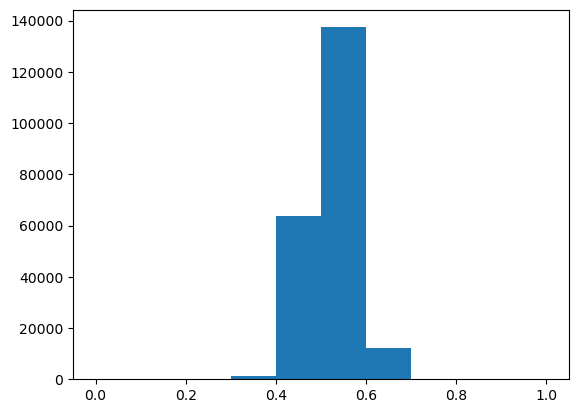

In [21]:
plt.hist(all_games['homewinprob'])